# Introduction

<img src="https://ichef.bbci.co.uk/news/1024/cpsprodpb/11893/production/_108472817_08472816.jpg" width="600">

이전 [Game_Network_Analysis_1_EDA](https://github.com/SSANGMAN/WoW-Network-Analysis/blob/master/ipynb/Game_Network_Analysis_1_EDA.ipynb)에서는 월드 오브 워크래프트의 단일 데이터 셋에 대한 이해 및 간단한 EDA를 수행했습니다. 이제, 다중 데이터 셋을 이용하여 더 심층적인 EDA를 수행합니다.

# Import Module

In [38]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

import plotly.express as px
import plotly.graph_objects as go

import os
import warnings 
warnings.filterwarnings('ignore')
print(os.listdir('../dataset'))

['locations.csv', 'location_coords.csv', 'wowah_data.csv', 'zones.csv']


# Prepare Dataset

## Define Function

In [39]:
## Function to reduce the DF size
## Source kernel: https://www.kaggle.com/arjanso/reducing-dataframe-memory-size-by-65
def reduce_mem_usage(df, verbose=True):
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2    
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)  
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)    
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose: print('Mem. usage decreased to {:5.2f} Mb ({:.1f}% reduction)'.format(end_mem, 100 * (start_mem - end_mem) / start_mem))
    return df

## Load Data

In [40]:
location = pd.read_csv('../dataset/locations.csv', encoding = 'unicode_escape')
location_coord = pd.read_csv('../dataset/location_coords.csv', encoding = 'unicode_escape')
wowah_data = pd.read_csv('../dataset/wowah_data.csv', encoding = 'unicode_escape')
wowah_data = reduce_mem_usage(wowah_data)
zones = pd.read_csv('../dataset/zones.csv', encoding = 'unicode_escape')

Mem. usage decreased to 402.68 Mb (30.4% reduction)


# Location & Location Coordination

Location 데이터는 지역에 대한 형태(Location_Type), 지역 이름(Location_Name), 출시 게임 버전(Game_Version)에 대한 정보입니다. 

Location Coordination 데이터는 지역 이름(Location_Name)과 좌표에 대한 정보입니다.

두 데이터는 Map_ID를 통해 병합이 가능합니다. 데이터를 병합을 수행합니다.

In [41]:
location.head()

,Map_ID,Location_Type,Location_Name,Game_Version
0,0,Continent,Eastern Kingdoms,WoW
1,1,Continent,Kalimdor,WoW
2,530,Continent,Outlands,TBC
3,571,Continent,Northrend,WLK
4,646,Continent,Deepholm,CAT


In [42]:
location_coord.head()

,Location_Name,Map_ID,X_coord,Y_coord,Z_coord
0,Eastern Kingdom: Ironforge Airport,0.0,-4488.993311,-1580.19104,509.005066
1,Eastern Kingdom: Wetlands Mountain Camp,0.0,-3855.000000,-3479.00000,579.000000
2,Eastern Kingdom: Dun Morogh plane camp,0.0,-6161.000000,-786.00000,423.000000
3,Eastern Kingdom: Undercity,0.0,1831.260000,238.53000,60.520000
4,Eastern Kingdom: Stormwind City,0.0,-8913.230000,554.63300,93.794400


두 데이터의 공통 컬럼인 Location_Name은 형태가 서로 다르다는 것을 알 수 있습니다. 

데이터를 확인해보면, Location Coordination의 Location_Name 컬럼이 더 자세한 것을 알 수 있습니다.

또한, Location 데이터의 컬럼값과 중복되는 내용이 존재합니다. 따라서 ":" 전후 문자열을 분할합니다.

In [43]:
split_loc_str = location_coord['Location_Name'].str.split(": ", expand = True)
split_loc_str

,0,1,2
0,Eastern Kingdom,Ironforge Airport,None
1,Eastern Kingdom,Wetlands Mountain Camp,None
2,Eastern Kingdom,Dun Morogh plane camp,None
3,Eastern Kingdom,Undercity,None
4,Eastern Kingdom,Stormwind City,None
...,...,...,...
3804,Terokkar Forest/Allerian Stronghold,None,None
3805,Hellfire Peninsula/The Stair of Destiny,None,None
3806,Shadowmoon Valley/Wildhammer Stronghold,None,None
3807,Blade's Edge Mountains/Toshley's Station,None,None


예외적인 분할 결과(index: 3804 ~ 3808)가 존재한다는 것을 알 수 있습니다. 

또한 특이하게, 두 번 분할된 경우도 존재한다는 결과가 나왔습니다. 먼저 이를 확인합니다.

In [44]:
location_coord = pd.concat([location_coord, split_loc_str], axis = 1)
location_coord.rename(columns = {0:'loc_name_first', 1:'loc_name_second', 2:'loc_name_third'}, inplace = True)

location_coord.loc[~location_coord['loc_name_third'].isnull()]

,Location_Name,Map_ID,X_coord,Y_coord,Z_coord,loc_name_first,loc_name_second,loc_name_third
848,Blade's Edge Mountains : Forge Camp: Anger,530.0,2946.400000,4837.720000,277.624000,Blade's Edge Mountains,Forge Camp,Anger
849,Blade's Edge Mountains : Forge Camp: Terror,530.0,1506.860000,7303.650000,367.062000,Blade's Edge Mountains,Forge Camp,Terror
850,Blade's Edge Mountains : Forge Camp: Wrath,530.0,2943.300000,6962.010000,365.407000,Blade's Edge Mountains,Forge Camp,Wrath
1161,Hellfire Peninsula : Forge Camp: Mageddon,530.0,382.590000,2186.890000,118.380000,Hellfire Peninsula,Forge Camp,Mageddon
1162,Hellfire Peninsula : Forge Camp: Rage,530.0,398.865000,2501.620000,148.810000,Hellfire Peninsula,Forge Camp,Rage
1167,Hellfire Peninsula : Invasion Point: Annihilator,530.0,538.373000,2766.970000,214.837000,Hellfire Peninsula,Invasion Point,Annihilator
1267,Nagrand : Forge Camp: Fear,530.0,-1845.690000,9245.250000,70.502500,Nagrand,Forge Camp,Fear
1268,Nagrand : Forge Camp: Hate,530.0,-1317.730000,8929.640000,53.693100,Nagrand,Forge Camp,Hate
1309,Netherstorm : Forge Base: Gehenna,530.0,4635.560000,3220.840000,158.043000,Netherstorm,Forge Base,Gehenna
1310,Netherstorm : Forge Base: Oblivion,530.0,4456.360000,3414.980000,162.638000,Netherstorm,Forge Base,Oblivion


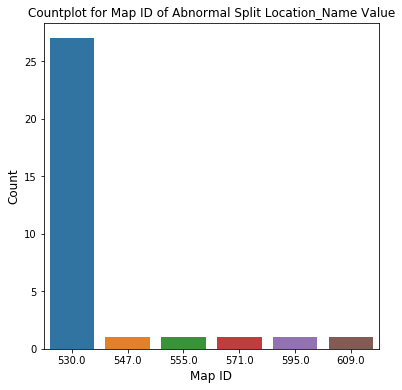

In [45]:
plt.figure(figsize = (6,6))

sns.countplot(location_coord.loc[~location_coord['loc_name_third'].isnull()]['Map_ID'])

plt.title('Countplot for Map ID of Abnormal Split Location_Name Value', fontsize = 12)
plt.xlabel('Map ID', fontsize = 12)
plt.ylabel('Count', fontsize = 12)

plt.show()

이상하게도, Map ID 값이 530인 관측값들에서 특히 많이 발생한다는 것을 알 수 있습니다. 

따라서, 원자료에 존재하는 Map ID 530을 다시 확인합니다.

In [46]:
map_id_530_split = location_coord.loc[location_coord['Map_ID'] == 530]['Location_Name'].str.split(": ", expand = True)
print("Number of rows with map ID 530 : {}".format(len(map_id_530_split)))
print("Location Unique Value with Map ID 530 :", print(map_id_530_split[0].unique()))
map_id_530_split.head()

Number of rows with map ID 530 : 1018
['Arcatraz' 'Azuremyst Isle' 'Black Temple' "Blade's Edge Mountains"
 'Bloodmyst Isle' 'Botanica' 'Exodar' 'Ghostlands' "Gruul's Lair"
 'Hellfire Peninsula' 'Nagrand' 'Netherstorm' 'North Sea'
 'Shadowmoon Valley' 'Tempest Keep' 'Terokkar Forest' 'theexodar'
 'Silvermoon City    ' 'Netherstorm     ' "Blade's Edge Mountains   "
 'North Sea Eversong Woods ' 'Azuremyst Isle    ' 'Ghostlands     '
 'Zangarmarsh     ' 'Nagrand     ' 'Bloodmyst Isle    '
 'Terokkar Forest entrance   ' 'Shadowmoon Valley    '
 'Top of Black Temple ' 'Exodar     ' 'Silvermoon City     '
 "Silvermoon City - Sheperd's Gate " 'party netherstorm    '
 'North Sea - Eversong Woods' 'Silvermoon City' 'Zangarmarsh'
 'Terokkar Forest entrance' 'Top of Black Temple' 'Shattrath City'
 'Azuremyst Isle ' "Blade's Edge Mountains " 'Bloodmyst Isle '
 'Eversong Woods ' 'Ghostlands ' 'Hellfire Peninsula ' 'Nagrand '
 'Netherstorm ' 'Shadowmoon Valley ' 'Shattrath City ' 'Silvermoon City '


,0,1,2
301,Arcatraz,None,None
304,Azuremyst Isle,None,None
313,Black Temple,None,None
315,Blade's Edge Mountains,None,None
317,Bloodmyst Isle,None,None


일반적인 Location_Name 값은 대륙: 지역명 입니다. 

그러나, 그렇지 않은 값들이 존재한다는 것을 알 수 있습니다. 

특히, Map ID: 530일 경우 그런 값들이 많이 존재합니다. 

확인 결과, 월드 오브 워크래프트: 불타는 성전에 출시한 대륙 (아웃랜드)이 대부분이라는 것을 알 수 있습니다.

<img src="https://gamepedia.cursecdn.com/wowpedia/thumb/7/75/WorldMap-Outland_Updated.jpg/1280px-WorldMap-Outland_Updated.jpg" width="600">

## Azeroth
Map ID: 530이 아웃랜드라고 단정할 수 없는 이유는 Silvermoon과 Exodar는 Eastern Kingdom(동부 왕국)과 Kalimdor(칼림도어 대륙)에 속해있기 때문입니다.

따라서, Silvermoon City와 Exodar는 각각 Eastern Kingdom: Silvermoon과 Kailmdor: Exodar로 변경합니다. 또한, Map_ID를 0(Eastern Kingdoms), 1(Kailmdor)로 변경합니다.

또한, Silvermoon City와 Exodar City 근방에 존재하는 지역은 월드 오브 워크래프트: 불타는 성전에 새롭게 등장한 지역이므로 구분해야 합니다. 

### Silvermoon

<img src="https://github.com/SSANGMAN/WoW-Network-Analysis/blob/master/image/Silvermoon.PNG?raw=true" width="600">

Location_Name 문자열 내에 Silvermoon이 포함된 값들을 확인합니다.

In [47]:
location_coord.loc[location_coord.iloc[:,0].str.contains(r'Silvermoon')].head()

,Location_Name,Map_ID,X_coord,Y_coord,Z_coord,loc_name_first,loc_name_second,loc_name_third
404,Silvermoon City,530.0,9851.0000,-7500.0000,-4.0000,Silvermoon City,None,None
408,Silvermoon City,530.0,9851.0000,-7500.0000,-4.0000,Silvermoon City,None,None
477,Silvermoon City,530.0,9416.0996,-6780.8979,14.8920,Silvermoon City,None,None
478,Silvermoon City - Sheperd's Gate,530.0,9334.1855,-7277.1816,14.5106,Silvermoon City - Sheperd's Gate,None,None
650,Silvermoon City,530.0,9851.0000,-7500.0000,-4.0000,Silvermoon City,None,None


확인 결과, Slivermoon 내에 존재하는 지역들의 세부 정보가 포함되어 있습니다. 

이 노트북에서는 포괄적인 분석을 위하여 모두 Eastern Kingdom: Silvermoon과 Map_ID를 0으로 통일합니다.

In [48]:
location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Silvermoon'), 'Location_Name'] = 'Eastern Kingdom: Silvermoon City'
location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Silvermoon'), 'Map_ID'] = 0

location_coord.loc[location_coord['Location_Name'] == 'Eastern Kingdom: Silvermoon City'].head()

,Location_Name,Map_ID,X_coord,Y_coord,Z_coord,loc_name_first,loc_name_second,loc_name_third
404,Eastern Kingdom: Silvermoon City,0.0,9851.0000,-7500.0000,-4.0000,Silvermoon City,None,None
408,Eastern Kingdom: Silvermoon City,0.0,9851.0000,-7500.0000,-4.0000,Silvermoon City,None,None
477,Eastern Kingdom: Silvermoon City,0.0,9416.0996,-6780.8979,14.8920,Silvermoon City,None,None
478,Eastern Kingdom: Silvermoon City,0.0,9334.1855,-7277.1816,14.5106,Silvermoon City - Sheperd's Gate,None,None
650,Eastern Kingdom: Silvermoon City,0.0,9851.0000,-7500.0000,-4.0000,Silvermoon City,None,None


#### Eversong Wood
월드 오브 워크래프트: 불타는 성전의 출시로 Silvermoon과 함께 등장한 신규 지역은 Eversong Wood와 Ghostlands입니다. 


<img src="https://github.com/SSANGMAN/WoW-Network-Analysis/blob/master/image/Eversongwood.PNG?raw=true" width="600">

여기서 주의해야 할 점은 Location_Name의 종족 대도시 값은 모두 Eastern Kingdom: 및 Kalimdor: 문자열이 앞에 존재한다는 것입니다.

반면, 그외 지역은 해당 문자열이 존재하지 않습니다.

따라서 대도시 값을 제외한 지역 값은 '지역 : 세부 지역'으로 모두 통일합니다. 

또한, 이러한 형태를 가지지 않는 값들은 모두 제거하겠습니다.

In [49]:
eversong = location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Eversong')]
eversong.loc[location_coord.iloc[:,0].str.contains(r'Eversong Woods : '),'Location_Name'] = eversong.loc[location_coord.iloc[:,0].str.contains(r'Eversong Woods : ')]['Location_Name'].apply(lambda x: 'Eversong Woods:{}'.format(x[16:]))

location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Eversong'), 'Location_Name'] = eversong
location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Eversong Woods: '), 'Map_ID'] = 0

location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Eversong Woods: ')].head()

,Location_Name,Map_ID,X_coord,Y_coord,Z_coord,loc_name_first,loc_name_second,loc_name_third
1067,Eversong Woods: Azurebreeze Coast,0.0,9619.29,-8049.84,0.474619,Eversong Woods,Azurebreeze Coast,None
1068,Eversong Woods: Dawning Lane,0.0,9709.50,-6649.06,6.382600,Eversong Woods,Dawning Lane,None
1069,Eversong Woods: Duskwither Grounds,0.0,9499.94,-7868.79,16.128100,Eversong Woods,Duskwither Grounds,None
1070,Eversong Woods: Duskwither Spire,0.0,9336.16,-7884.23,158.445000,Eversong Woods,Duskwither Spire,None
1071,Eversong Woods: East Sanctum,0.0,8748.17,-7078.31,37.276000,Eversong Woods,East Sanctum,None


In [50]:
eversong_drop_index = location_coord.loc[~(location_coord.iloc[:, 0].str.contains(r'Eversong Woods:')) & (location_coord.iloc[:, 0].str.contains(r'Eversong Woods'))].index
location_coord = location_coord.drop(eversong_drop_index)

#### Ghostlands

Bloodmyst Isle에 대한 Location_Name 문자열 값을 정리합니다.

<img src="https://github.com/SSANGMAN/WoW-Network-Analysis/blob/master/image/Ghostlands.PNG?raw=true" width="600">

In [51]:
ghostland = location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Ghostlands')]
ghostland.loc[location_coord.iloc[:, 0].str.contains(r'Ghostlands : '), 'Location_Name'] = ghostland.loc[location_coord.iloc[:, 0].str.contains(r'Ghostlands : ')]['Location_Name'].apply(lambda x: 'Ghostlands:{}'.format(x[11:]))

location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Ghostlands'), 'Location_Name'] = ghostland
location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Ghostlands: '), 'Map_ID'] = 0

location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Ghostlands: ')].head()

,Location_Name,Map_ID,X_coord,Y_coord,Z_coord,loc_name_first,loc_name_second,loc_name_third
2563,Ghostlands: Amani Catacombs,0.0,7636.130000,-7359.080000,162.328000,Ghostlands,Amani Catacombs,None
2564,Ghostlands: Amani Pass,0.0,6847.640000,-7750.870000,122.616000,Ghostlands,Amani Pass,None
2565,Ghostlands: An'daroth,0.0,7911.228027,-6507.747070,46.816975,Ghostlands,An'daroth,None
2566,Ghostlands: An'owyn,0.0,6832.454102,-7190.099609,25.314520,Ghostlands,An'owyn,None
2567,Ghostlands: An'telas,0.0,7449.607422,-7295.749512,95.320755,Ghostlands,An'telas,None


In [52]:
ghostland_drop_index = location_coord.loc[~(location_coord.iloc[:, 0].str.contains(r'Ghostlands:')) & (location_coord.iloc[:, 0].str.contains(r'Ghostlands'))].index
location_coord = location_coord.drop(ghostland_drop_index)

### Exodar

<img src="https://github.com/SSANGMAN/WoW-Network-Analysis/blob/master/image/Exodar.PNG?raw=true" width="600">

Location_Name 문자열 내에 Exodar가 포함된 값들을 확인합니다.

In [53]:
location_coord.loc[location_coord.iloc[:,0].str.contains(r'Exodar')].head()

,Location_Name,Map_ID,X_coord,Y_coord,Z_coord,loc_name_first,loc_name_second,loc_name_third
332,Exodar,530.0,-4014.080000,-11895.800000,-0.993240,Exodar,None,None
476,Exodar,530.0,-4010.137900,-11888.649400,-1.670900,Exodar,None,None
793,Azuremyst Isle : Exodar Entrance,530.0,-4021.450000,-11911.400000,-2.232150,Azuremyst Isle,Exodar Entrance,None
1539,Exodar : Exodar,530.0,-4017.961426,-11899.289063,-1.083418,Exodar,Exodar,None
1540,Exodar : Seat of Naaru,530.0,-3826.680000,-11686.900000,-107.044000,Exodar,Seat of Naaru,None


확인 결과, Exodar 내에 존재하는 지역들의 세부 정보가 포함되어 있습니다. 

이 노트북에서는 포괄적인 분석을 위하여 모두 Kalimdor: Exodar City와 Map_ID를 1로 통일합니다.

In [54]:
location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Exodar'), 'Location_Name'] = 'Kalimdor: Exodar City'
location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Exodar'), 'Map_ID'] = 1

location_coord.loc[location_coord['Location_Name'] == 'Kalimdor: Exodar City'].head()

,Location_Name,Map_ID,X_coord,Y_coord,Z_coord,loc_name_first,loc_name_second,loc_name_third
332,Kalimdor: Exodar City,1.0,-4014.080000,-11895.800000,-0.993240,Exodar,None,None
476,Kalimdor: Exodar City,1.0,-4010.137900,-11888.649400,-1.670900,Exodar,None,None
793,Kalimdor: Exodar City,1.0,-4021.450000,-11911.400000,-2.232150,Azuremyst Isle,Exodar Entrance,None
1539,Kalimdor: Exodar City,1.0,-4017.961426,-11899.289063,-1.083418,Exodar,Exodar,None
1540,Kalimdor: Exodar City,1.0,-3826.680000,-11686.900000,-107.044000,Exodar,Seat of Naaru,None


#### Azuremyst Isle

월드 오브 워크래프트: 불타는 성전의 출시로 Exodar와 함께 등장한 신규 지역은 Azuremyst Isle과 Bloodmyst Isle 입니다.

Azuremyst Isle에 대한 Location_Name 문자열 값을 정리합니다.

<img src="https://github.com/SSANGMAN/WoW-Network-Analysis/blob/master/image/Azuremystlsle.PNG?raw=true" width="600">

이전과 같은 방법으로 'Azuremyst Isle: Value'로 값을 통일합니다.

In [55]:
azuremyst = location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Azuremyst')]
azuremyst.loc[location_coord.iloc[:,0].str.contains(r'Azuremyst Isle : '),'Location_Name'] = azuremyst.loc[location_coord.iloc[:,0].str.contains(r'Azuremyst Isle : ')]['Location_Name'].apply(lambda x: 'Azuremyst Isle:{}'.format(x[16:]))

location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Azuremyst'), 'Location_Name'] = azuremyst
location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Azuremyst Isle: '), 'Map_ID'] = 1

location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Azuremyst Isle: ')].head()

,Location_Name,Map_ID,X_coord,Y_coord,Z_coord,loc_name_first,loc_name_second,loc_name_third
771,Azuremyst Isle: Ammen Fields,1.0,-4156.72,-13486.0,46.199900,Azuremyst Isle,Ammen Fields,None
772,Azuremyst Isle: Ammen Ford,1.0,-4240.31,-13036.1,-0.275967,Azuremyst Isle,Ammen Ford,None
773,Azuremyst Isle: Ammen Vale,1.0,-3967.45,-13657.6,60.397700,Azuremyst Isle,Ammen Vale,None
774,Azuremyst Isle: Azure Watch,1.0,-4183.30,-12515.0,44.377000,Azuremyst Isle,Azure Watch,None
775,Azuremyst Isle: Bristlelimb Village,1.0,-4615.48,-11599.4,18.303300,Azuremyst Isle,Bristlelimb Village,None


In [56]:
azuremyst_drop_index = location_coord.loc[~(location_coord.iloc[:, 0].str.contains(r'Azuremyst Isle:')) & (location_coord.iloc[:, 0].str.contains(r'Azuremyst Isle'))].index
location_coord = location_coord.drop(azuremyst_drop_index)

#### Bloodmyst Isle

Bloodmyst Isle에 대한 Location_Name 문자열 값을 정리합니다.

<img src="https://github.com/SSANGMAN/WoW-Network-Analysis/blob/master/image/BloodmystIsle.PNG?raw=true" width="600">

In [57]:
bloodmyst = location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Bloodmyst')]
bloodmyst.loc[location_coord.iloc[:, 0].str.contains(r'Bloodmyst Isle : '), 'Location_Name'] = bloodmyst.loc[location_coord.iloc[:, 0].str.contains(r'Bloodmyst Isle : ')]['Location_Name'].apply(lambda x: 'Bloodmyst Isle:{}'.format(x[16:]))

location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Bloodmyst'), 'Location_Name'] = bloodmyst
location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Bloodmyst Isle: '), 'Map_ID'] = 1

location_coord.loc[location_coord.iloc[:, 0].str.contains(r'Bloodmyst Isle: ')].head()

,Location_Name,Map_ID,X_coord,Y_coord,Z_coord,loc_name_first,loc_name_second,loc_name_third
881,Bloodmyst Isle: Amberweb Pass,1.0,-1631.36,-10671.5,143.441000,Bloodmyst Isle,Amberweb Pass,None
882,Bloodmyst Isle: Axxarien,1.0,-1504.03,-11406.3,67.889300,Bloodmyst Isle,Axxarien,None
883,Bloodmyst Isle: Beryl Coast,1.0,-2677.72,-12363.2,0.345755,Bloodmyst Isle,Beryl Coast,None
884,Bloodmyst Isle: Blacksilt Shore,1.0,-2831.77,-11294.6,2.317740,Bloodmyst Isle,Blacksilt Shore,None
885,Bloodmyst Isle: Bladewood,1.0,-1785.28,-11611.0,35.421300,Bloodmyst Isle,Bladewood,None


In [58]:
bloodmyst_drop_index = location_coord.loc[~(location_coord.iloc[:, 0].str.contains(r'Bloodmyst Isle:')) & (location_coord.iloc[:, 0].str.contains(r'Bloodmyst Isle'))].index
location_coord = location_coord.drop(bloodmyst_drop_index)

In [59]:
location_coord.reset_index(drop = True, inplace = True)

### ETC.

TO-DO

## Outland

이제, 아웃랜드에 해당하는 값들은 모두 Outland: Value로 변경합니다. 

변경 전, Outland - Value인 값들이 존재하는데, - 이전의 문자열은 모두 제거합니다. 

In [30]:
location_coord.loc[location_coord['Map_ID'] == 530]['Location_Name']

301                                     Arcatraz
312                                 Black Temple
314                       Blade's Edge Mountains
316                               Bloodmyst Isle
317                                     Botanica
                          ...                   
3789               Hellfire Peninsula/Honor Hold
3790         Terokkar Forest/Allerian Stronghold
3791     Hellfire Peninsula/The Stair of Destiny
3792     Shadowmoon Valley/Wildhammer Stronghold
3793    Blade's Edge Mountains/Toshley's Station
Name: Location_Name, Length: 830, dtype: object